# Modelización con aplicación de SMOTE

## Importación de librerías

In [1]:
# Librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para manipulación y análisis de datos
import numpy as np
import pandas as pd


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline


from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, recall_score, auc

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


from toolbox_DS import *
from toolbox_ML import *


import warnings
warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')


## Carga de datos

Train

In [2]:
train_set = pd.read_csv('./data/train_set.csv')
train_set

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Response,income_missing,age,customes_seniority,Household_members,Total_amount,Total_purchase,Median_amount_purchase,Total_cmp,Total_%_cmp
0,5675,1960,PhD,Divorced,50611.0,0,1,2012-10-04,98,459,...,0,0,55,3,2.0,493,22,22.409091,1,0.2
1,5543,1966,Graduation,Together,57811.0,0,1,2013-06-24,49,545,...,0,0,49,2,3.0,802,25,32.080000,1,0.2
2,3011,1965,Graduation,Married,69139.0,0,1,2014-01-27,23,86,...,0,0,50,1,3.0,227,11,20.636364,0,0.0
3,535,1987,Graduation,Divorced,81361.0,0,0,2014-02-25,18,163,...,0,0,28,1,1.0,778,27,28.814815,0,0.0
4,10755,1976,2n Cycle,Married,23718.0,1,0,2013-09-02,76,6,...,0,0,39,2,3.0,81,9,9.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785,5320,1973,Master,Divorced,44051.0,1,1,2013-01-29,20,79,...,1,0,42,2,3.0,171,12,14.250000,0,0.0
1786,2894,1985,Graduation,Single,72903.0,0,0,2013-10-29,74,1067,...,1,0,30,2,1.0,2013,21,95.857143,3,0.6
1787,1726,1970,Graduation,Single,22585.0,0,0,2013-03-18,23,3,...,1,0,45,2,1.0,81,5,16.200000,1,0.2
1788,6905,1994,Graduation,Together,80685.0,0,0,2012-08-22,55,241,...,0,0,21,3,2.0,1004,21,47.809524,0,0.0


Test

In [3]:
test_set = pd.read_csv('./data/test_set.csv')
test_set.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Complain,Response,age,customes_seniority,Household_members,Total_amount,Total_purchase,Median_amount_purchase,Total_cmp,Total_%_cmp
0,2853,1980,Graduation,Single,51766.0,1,0,2014-03-11,74,60,...,0,0,35,1,2.0,275,12,22.916667,0,0.0
1,10492,1959,Graduation,Together,38285.0,2,1,2014-06-24,96,2,...,0,0,56,1,5.0,10,4,2.500000,0,0.0
2,8939,1959,Graduation,Divorced,61250.0,0,1,2012-12-16,49,382,...,0,0,56,3,2.0,730,25,29.200000,0,0.0
3,6274,1948,Master,Married,83790.0,0,0,2013-11-15,81,1076,...,0,0,67,2,2.0,1615,25,64.600000,2,0.4
4,10232,1963,PhD,Divorced,48799.0,0,1,2013-11-05,9,174,...,0,0,52,2,2.0,331,15,22.066667,0,0.0


Imputo los cambios que vengo aplicando al dataset.    
Train

In [4]:
# Cambio el índice
train_set.set_index('ID', inplace=True)

# Cambio tipo a datetime
train_set['Dt_Customer'] = pd.to_datetime(train_set['Dt_Customer'])

# Cambiar tipo a categóricas
cols_to_category = ['Education', 'Marital_Status']
train_set[cols_to_category] = train_set[cols_to_category].astype('category')

# Elimino columna 'income_missing'
train_set = train_set.drop(columns=['income_missing', 'Year_Birth','Total_%_cmp','Dt_Customer','Median_amount_purchase'])

# Elimino el outlier de Income
train_set = train_set.loc[train_set['Income'] !=666666]

Y también al test

In [5]:
# Cambio el índice
test_set.set_index('ID', inplace=True)

# Cambio tipo a datetime
test_set['Dt_Customer'] = pd.to_datetime(test_set['Dt_Customer'])

# Cambiar tipo a categóricas
cols_to_category = ['Education', 'Marital_Status']
test_set[cols_to_category] = test_set[cols_to_category].astype('category')

# Elimino columna 'income_missing'
test_set = test_set.drop(columns=['Year_Birth','Total_%_cmp','Dt_Customer','Median_amount_purchase'])

# Elimino el outlier de Income
test_set = test_set.loc[test_set['Income'] !=666666]

## Transformación de variables

In [6]:
X_train = train_set.drop(columns='Response')
y_train = train_set['Response']

X_test = test_set.drop(columns='Response')
y_test = test_set['Response']

In [7]:
features_num = X_train.select_dtypes(['int','float']).columns
features_cat = X_train.select_dtypes(['object', 'category']).columns
print('features_num', features_num)
print('features_cat', features_cat)

features_num Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'age', 'customes_seniority',
       'Household_members', 'Total_amount', 'Total_purchase', 'Total_cmp'],
      dtype='object')
features_cat Index(['Education', 'Marital_Status'], dtype='object')


In [8]:
# Definimos el OrdinalEncoder con el mapeo de 'education_ode'
ordinal_encoder = OrdinalEncoder(categories=[['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']])

categorical_features_onehot = ['Marital_Status']
categorical_features_ordinal = ['Education']
numerical_features = features_num

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat_onehot', OneHotEncoder(), categorical_features_onehot),
        ('cat_ordinal', Pipeline([
            ('ordinal', ordinal_encoder),
            ('scaler', MinMaxScaler())
        ]), categorical_features_ordinal)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocesor',preprocessor),
    ('algoritmo', RandomForestClassifier())
])

pipeline.fit(X_train,y_train)

X_train_transform = pipeline.named_steps['preprocesor'].transform(X_train)
X_test_transform = pipeline.named_steps['preprocesor'].transform(X_test)

In [9]:
features_transformed = pipeline.named_steps['preprocesor'].get_feature_names_out()
features_transformed

array(['num__Income', 'num__Kidhome', 'num__Teenhome', 'num__Recency',
       'num__MntWines', 'num__MntFruits', 'num__MntMeatProducts',
       'num__MntFishProducts', 'num__MntSweetProducts',
       'num__MntGoldProds', 'num__NumDealsPurchases',
       'num__NumWebPurchases', 'num__NumCatalogPurchases',
       'num__NumStorePurchases', 'num__NumWebVisitsMonth',
       'num__AcceptedCmp3', 'num__AcceptedCmp4', 'num__AcceptedCmp5',
       'num__AcceptedCmp1', 'num__AcceptedCmp2', 'num__Complain',
       'num__age', 'num__customes_seniority', 'num__Household_members',
       'num__Total_amount', 'num__Total_purchase', 'num__Total_cmp',
       'cat_onehot__Marital_Status_Alone',
       'cat_onehot__Marital_Status_Divorced',
       'cat_onehot__Marital_Status_Married',
       'cat_onehot__Marital_Status_Others',
       'cat_onehot__Marital_Status_Single',
       'cat_onehot__Marital_Status_Together',
       'cat_onehot__Marital_Status_Widow', 'cat_ordinal__Education'],
      dtype=object)

In [10]:
X_train_transform_df = pd.DataFrame(X_train_transform, columns=(features_transformed))
X_train_transform_df

,num__Income,num__Kidhome,num__Teenhome,num__Recency,num__MntWines,num__MntFruits,num__MntMeatProducts,num__MntFishProducts,num__MntSweetProducts,num__MntGoldProds,...,num__Total_purchase,num__Total_cmp,cat_onehot__Marital_Status_Alone,cat_onehot__Marital_Status_Divorced,cat_onehot__Marital_Status_Married,cat_onehot__Marital_Status_Others,cat_onehot__Marital_Status_Single,cat_onehot__Marital_Status_Together,cat_onehot__Marital_Status_Widow,cat_ordinal__Education
0,50611.0,0.0,1.0,98.0,459.0,0.0,24.0,6.0,0.0,4.0,...,22.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00
1,57811.0,0.0,1.0,49.0,545.0,7.0,114.0,37.0,21.0,78.0,...,25.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50
2,69139.0,0.0,1.0,23.0,86.0,12.0,75.0,33.0,15.0,6.0,...,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.50
3,81361.0,0.0,0.0,18.0,163.0,23.0,424.0,27.0,65.0,76.0,...,27.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.50
4,23718.0,1.0,0.0,76.0,6.0,3.0,14.0,15.0,7.0,36.0,...,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,44051.0,1.0,1.0,20.0,79.0,7.0,58.0,6.0,3.0,18.0,...,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.75
1785,72903.0,0.0,0.0,74.0,1067.0,138.0,750.0,0.0,19.0,39.0,...,21.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.50
1786,22585.0,0.0,0.0,23.0,3.0,9.0,15.0,13.0,2.0,39.0,...,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.50
1787,80685.0,0.0,0.0,55.0,241.0,45.0,604.0,34.0,26.0,54.0,...,21.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50


In [11]:
X_test_transform_df = pd.DataFrame(X_test_transform, columns=features_transformed)
X_test_transform_df

,num__Income,num__Kidhome,num__Teenhome,num__Recency,num__MntWines,num__MntFruits,num__MntMeatProducts,num__MntFishProducts,num__MntSweetProducts,num__MntGoldProds,...,num__Total_purchase,num__Total_cmp,cat_onehot__Marital_Status_Alone,cat_onehot__Marital_Status_Divorced,cat_onehot__Marital_Status_Married,cat_onehot__Marital_Status_Others,cat_onehot__Marital_Status_Single,cat_onehot__Marital_Status_Together,cat_onehot__Marital_Status_Widow,cat_ordinal__Education
0,51766.0,1.0,0.0,74.0,60.0,51.0,87.0,6.0,20.0,51.0,...,12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.50
1,38285.0,2.0,1.0,96.0,2.0,0.0,5.0,2.0,0.0,1.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50
2,61250.0,0.0,1.0,49.0,382.0,138.0,65.0,60.0,26.0,59.0,...,25.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.50
3,83790.0,0.0,0.0,81.0,1076.0,16.0,417.0,42.0,48.0,16.0,...,25.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.75
4,48799.0,0.0,1.0,9.0,174.0,18.0,81.0,28.0,6.0,24.0,...,15.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,62335.0,0.0,1.0,87.0,243.0,131.0,217.0,85.0,6.0,26.0,...,21.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.50
444,44393.0,1.0,1.0,86.0,24.0,2.0,20.0,2.0,2.0,10.0,...,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.50
445,54342.0,1.0,1.0,74.0,84.0,10.0,34.0,11.0,10.0,28.0,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.25
446,34421.0,1.0,0.0,81.0,3.0,3.0,7.0,6.0,2.0,9.0,...,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.50


## SMOTE

In [12]:
# Crear un objeto SMOTE
smote = SMOTE()

## Modelización

### Prueba de modelos con todas las variables

In [13]:
# ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
pipe = ImbPipeline(steps=[
    ('preprocesor', preprocessor),
    ('smote', smote),
    ('algoritmo', RandomForestClassifier())
])


# Definir el grid de hiperparámetros
grid = [
    {'algoritmo': [RandomForestClassifier()],
     'algoritmo__max_depth': [5, 10, 15],
     'algoritmo__n_estimators': [50, 100, 200],
     },
   
    {'algoritmo': [XGBClassifier()],
     'algoritmo__learning_rate': [0.1, 0.3, 0.5],
     'algoritmo__n_estimators': [100, 500, 1000],
     },
    
    {'algoritmo': [LGBMClassifier()],
     'algoritmo__learnin_rate': [0.1, 0.3, 0.5],
     'algoritmo__n_estimators': [100, 500, 1000],
     'algoritmo__objective': ['binary']}
]


# Realizar GridSearchCV con el scorer personalizado
grid_search = GridSearchCV(pipe, 
                           grid, 
                           cv=5, 
                           scoring=make_scorer(recall_score, pos_label=True), 
                           n_jobs=-1)


grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y parámetros
best_model = grid_search.best_estimator_
print("Mejor modelo y parámetros:", grid_search.best_params_)

c:\Users\Alfonso\miniconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Mejor modelo y parámetros: {'algoritmo': RandomForestClassifier(), 'algoritmo__max_depth': 5, 'algoritmo__n_estimators': 50}


In [14]:
grid_search.best_score_

nan

In [15]:
df_cv_results = pd.DataFrame(grid_search.cv_results_)
df_cv_results[['param_algoritmo','mean_test_score','std_test_score','rank_test_score']].sort_values('rank_test_score')

,param_algoritmo,mean_test_score,std_test_score,rank_test_score
0,RandomForestClassifier(),NaN,NaN,1
24,LGBMClassifier(),NaN,NaN,1
23,LGBMClassifier(),NaN,NaN,1
22,LGBMClassifier(),NaN,NaN,1
21,LGBMClassifier(),NaN,NaN,1
20,LGBMClassifier(),NaN,NaN,1
19,LGBMClassifier(),NaN,NaN,1
18,LGBMClassifier(),NaN,NaN,1
17,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,1
16,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,1


Haciendo un pipeline con todas las variables, el mejor sería un RandomForest con una recall de la clase positiva de 0.66

## Ajuste hiperparámetros

In [16]:
smote = SMOTE(k_neighbors=5,random_state=42) # He metido 5 k_neighbours
X_train_smote, y_train_smote = smote.fit_resample(X_train_transform_df,y_train)
y_train_smote.value_counts()

Response
0    1523
1    1523
Name: count, dtype: int64

In [17]:
# Instancio modelos (quitando el balanceo de clases)

xgb = XGBClassifier(max_depth=10, random_state = 42)
rf = RandomForestClassifier(max_depth=10, random_state=42)
lgb = LGBMClassifier(max_depth=10, objective= 'binary', random_state = 42, verbose = -1)

### RandomForest

In [18]:


param = {
    'n_estimators': [100,200,300,400],
    'max_depth': [4, 5,6],
    'min_samples_split': [3,4,5],
    'min_samples_leaf': [8,10,12],
    
}

grid_rf = GridSearchCV(rf, 
                       param_grid=param, 
                       cv=5, 
                       scoring=make_scorer(recall_score, pos_label=True), 
                       n_jobs=-1)

grid_rf.fit(X_train_smote, y_train_smote)

# Obtener el mejor modelo y parámetros
best_model_rf = grid_rf.best_estimator_
best_params_rf = grid_rf.best_params_
print("Mejor modelo y parámetros:", best_params_rf)

# Imprimir el mejor resultado del recall para la clase positiva
best_recall_rf = grid_rf.best_score_
print("Mejor resultado del recall para la clase positiva:", best_recall_rf)


Mejor modelo y parámetros: {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 200}
Mejor resultado del recall para la clase positiva: 0.8779896462467643


Mejor modelo y parámetros: {'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 3, 'n_estimators': 400}
Mejor resultado del recall para la clase positiva: 0.877318809318378

In [19]:
importancias = best_model_rf.feature_importances_
nombres_caracteristicas = X_train_transform_df.columns

importancias_df = pd.DataFrame({
    'Característica': nombres_caracteristicas,
    'Importancia': importancias
})

importancias_df.sort_values(by='Importancia', ascending=False, inplace=True)

print(importancias_df)

                         Característica  Importancia
26                       num__Total_cmp     0.198215
22              num__customes_seniority     0.101877
15                    num__AcceptedCmp3     0.091837
17                    num__AcceptedCmp5     0.059063
18                    num__AcceptedCmp1     0.055910
3                          num__Recency     0.043981
23               num__Household_members     0.039584
29   cat_onehot__Marital_Status_Married     0.033456
12             num__NumCatalogPurchases     0.032106
2                         num__Teenhome     0.029927
9                     num__MntGoldProds     0.029064
14               num__NumWebVisitsMonth     0.027488
31    cat_onehot__Marital_Status_Single     0.026609
24                    num__Total_amount     0.023376
16                    num__AcceptedCmp4     0.020306
0                           num__Income     0.019911
34               cat_ordinal__Education     0.019101
1                          num__Kidhome     0.

### LigthGBM

In [20]:
param = {
    'max_depth': [4,5, 6],
    'min_child_samples': [2,4,8],
    'min_child_weight': [4, 8,10],
    'learning_rate': [0.09, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'objective': ['binary'],
}

grid_lgb = GridSearchCV(lgb, 
                       param_grid=param, 
                       cv=5, 
                       scoring=make_scorer(recall_score, pos_label=True), 
                       n_jobs=-1,
                       verbose= 1)

grid_lgb.fit(X_train_smote, y_train_smote)

# Obtener el mejor modelo y parámetros
best_model_lgb = grid_lgb.best_estimator_
best_params_lgb = grid_lgb.best_params_
print("Mejor modelo y parámetros:", best_params_lgb)

# Imprimir el mejor resultado del recall para la clase positiva
best_recall_lgb = grid_lgb.best_score_
print("Mejor resultado del recall para la clase positiva:", best_recall_lgb)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejor modelo y parámetros: {'learning_rate': 0.09, 'max_depth': 6, 'min_child_samples': 2, 'min_child_weight': 4, 'n_estimators': 100, 'objective': 'binary'}
Mejor resultado del recall para la clase positiva: 0.877377049180328


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejor modelo y parámetros: {'is_unbalance': True, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_samples': 2, 'min_child_weight': 10, 'n_estimators': 100, 'objective': 'binary'}
Mejor resultado del recall para la clase positiva: 0.8839322691975842

In [21]:
importancias = best_model_lgb.feature_importances_
nombres_caracteristicas = X_train_transform_df.columns

importancias_df = pd.DataFrame({
    'Característica': nombres_caracteristicas,
    'Importancia': importancias
})

importancias_df.sort_values(by='Importancia', ascending=False, inplace=True)

print(importancias_df)

                         Característica  Importancia
3                          num__Recency          221
26                       num__Total_cmp          146
22              num__customes_seniority          146
13               num__NumStorePurchases          126
6                  num__MntMeatProducts          108
0                           num__Income           97
5                        num__MntFruits           91
4                         num__MntWines           90
21                             num__age           84
34               cat_ordinal__Education           81
9                     num__MntGoldProds           74
23               num__Household_members           74
7                  num__MntFishProducts           71
8                 num__MntSweetProducts           66
14               num__NumWebVisitsMonth           66
12             num__NumCatalogPurchases           61
29   cat_onehot__Marital_Status_Married           53
25                  num__Total_purchase       

### XGBoost

In [22]:


param = {
    'n_estimators': [100,200,300, 400],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [6, 8, 10],  # Equivalente a min_samples_leaf en RandomForest
    'gamma': [0, 0.1, 0.2],  # Parámetro para controlar la regularización
    'subsample': [0.6,0.7, 0.8, 0.9],  # Porcentaje de muestras usadas para cada árbol
    'colsample_bytree': [0.6,0.7, 0.8, 0.9],  # Porcentaje de características usadas para cada árbol
    
}


grid_xgb = GridSearchCV(xgb, 
                       param_grid=param, 
                       cv=5, 
                       scoring=make_scorer(recall_score, pos_label=True), 
                       n_jobs=-1,
                       verbose= 3)

grid_xgb.fit(X_train_smote, y_train_smote)

# Obtener el mejor modelo y parámetros
best_model_xgb = grid_xgb.best_estimator_
best_params_xgb = grid_xgb.best_params_
print("Mejor modelo y parámetros:", best_params_xgb)

# Imprimir el mejor resultado del recall para la clase positiva
best_recall_xgb = grid_xgb.best_score_
print("Mejor resultado del recall para la clase positiva:", best_recall_xgb)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
Mejor modelo y parámetros: {'colsample_bytree': 0.9, 'gamma': 0.1, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
Mejor resultado del recall para la clase positiva: 0.8845901639344262


Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
Mejor modelo y parámetros: {'colsample_bytree': 0.6, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.6}
Mejor resultado del recall para la clase positiva: 0.9199978429680759

In [23]:
importancias = best_model_xgb.feature_importances_
nombres_caracteristicas = X_train_transform_df.columns

importancias_df = pd.DataFrame({
    'Característica': nombres_caracteristicas,
    'Importancia': importancias
})

importancias_df.sort_values(by='Importancia', ascending=False, inplace=True)

print(importancias_df)

                         Característica  Importancia
26                       num__Total_cmp     0.233852
22              num__customes_seniority     0.109585
15                    num__AcceptedCmp3     0.099793
16                    num__AcceptedCmp4     0.052924
32  cat_onehot__Marital_Status_Together     0.052084
29   cat_onehot__Marital_Status_Married     0.048632
2                         num__Teenhome     0.043431
1                          num__Kidhome     0.043328
23               num__Household_members     0.034255
34               cat_ordinal__Education     0.028278
3                          num__Recency     0.024178
18                    num__AcceptedCmp1     0.022974
13               num__NumStorePurchases     0.016107
10               num__NumDealsPurchases     0.015603
12             num__NumCatalogPurchases     0.015023
17                    num__AcceptedCmp5     0.014941
0                           num__Income     0.014288
31    cat_onehot__Marital_Status_Single     0.

## Evaluación Modelos

#### Classification Report

In [24]:
# RandomForest
print('RandomForest')
y_pred_rf = grid_rf.predict(X_test_transform_df)

print(classification_report(y_test,y_pred_rf))
print()

# LigthGBM
print('LightGBM')
y_pred_lgb = grid_lgb.predict(X_test_transform_df)
print(classification_report(y_test,y_pred_lgb))
print()

# XGBoost
print('LightGBM')
y_pred_xgb = grid_xgb.predict(X_test_transform_df)
print(classification_report(y_test,y_pred_xgb))
print()



RandomForest
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       381
           1       0.55      0.48      0.51        67

    accuracy                           0.86       448
   macro avg       0.73      0.70      0.72       448
weighted avg       0.86      0.86      0.86       448


LightGBM
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       381
           1       0.65      0.45      0.53        67

    accuracy                           0.88       448
   macro avg       0.78      0.70      0.73       448
weighted avg       0.87      0.88      0.87       448


LightGBM
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       381
           1       0.68      0.51      0.58        67

    accuracy                           0.89       448
   macro avg       0.80      0.73      0.76       448
weighted avg       0.88      0.89      0.

RandomForest
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       381
           1       0.53      0.49      0.51        67

    accuracy                           0.86       448
   macro avg       0.72      0.71      0.71       448
weighted avg       0.86      0.86      0.86       448


LightGBM
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       381
           1       0.64      0.48      0.55        67

    accuracy                           0.88       448
   macro avg       0.78      0.72      0.74       448
weighted avg       0.87      0.88      0.87       448


LightGBM
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       381
           1       0.47      0.63      0.54        67

    accuracy                           0.84       448
   macro avg       0.70      0.75      0.72       448
weighted avg       0.86      0.84      0.85       448

#### Matrix de confusión

RandomForest

LightGBM

XGBoost



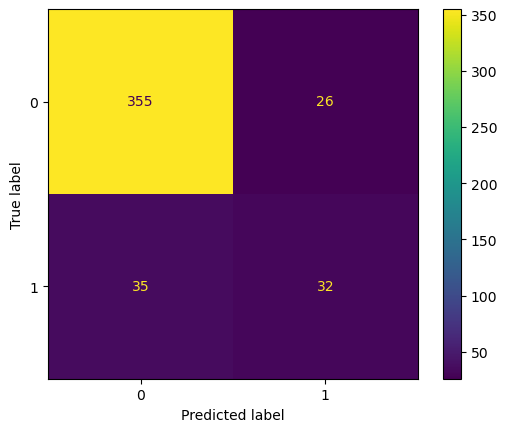

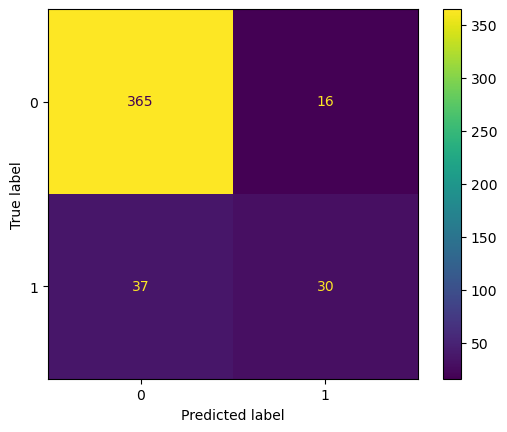

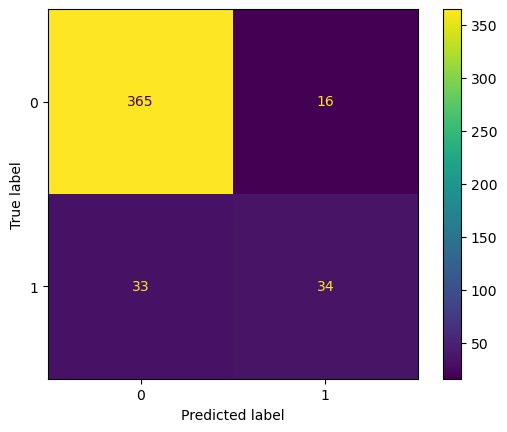

In [25]:
# RandomForest
print('RandomForest')
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
print()

# LightGBM
print('LightGBM')
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
disp_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_lgb)
disp_lgb.plot()
print()

# XGBoost
print('XGBoost')
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot()
print()

Los resultados en los datos de entrenamiento con la técnica de SMOTE han sido bastante mejores que sin ella, si bien, a la hora de evaluar contra test, el resultado es mucho mejor el del entrenamiento sin SMOTE.
El haber eliminado los parámetros de balanceo han hecho empeorar los resultados del recall de la clase positiva contra test.